# Model selection

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

## Bayesian Model Comparison <a class="anchor" id="two"></a>

Model comparison and hypothesis testing in Bayesian inference are enormously different from classical/frequentist statistics. ***In Bayesian inference, we probabilistically rank models based on how well they explain the data under our prior knowledge.*** Let's look back at how we assessed goodness-of-fit and model choice in frequentist statistics. 

Let's use the example from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
to illustrate some ideas about model selection.

In [3]:
from scipy import stats
from scipy import optimize
import numpy as np
import pylab as plt


# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.25,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

x,y, sigma_y = data

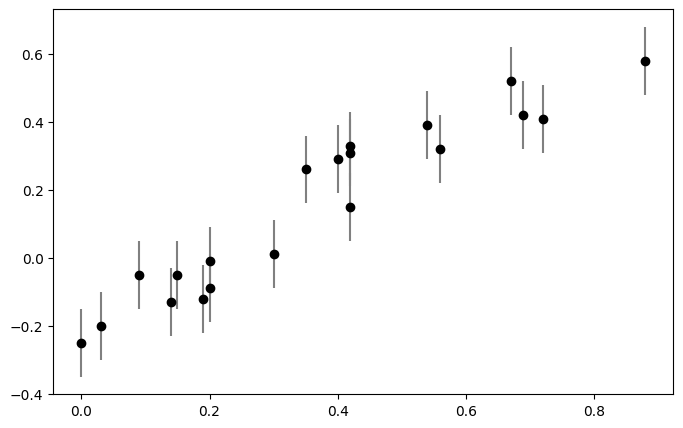

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray');

Is this data linear or quadratic? 

I best you've seen least-square fitting at some point in your career. You might also know that for Gaussian errors this is a equivalent to a maximum likelihood estimator. Let's do this quickly 

In [5]:
#Functions to do a polynomial fit, compute the likelihood, and determine the best-fit parameters.
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

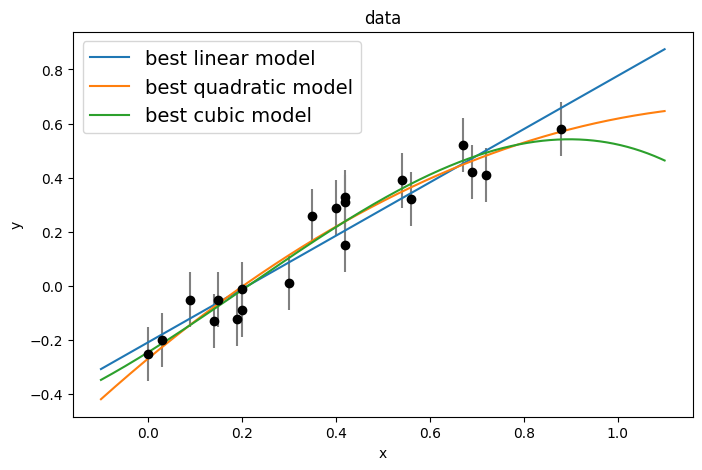

In [6]:
#Execute this cell.  See if you understand what it is doing.
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xgrid = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xgrid)
yfit2 = polynomial_fit(theta2, xgrid)
yfit3 = polynomial_fit(theta3, xgrid)

# plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit1, label='best linear model')
ax.plot(xgrid, yfit2, label='best quadratic model')
ax.plot(xgrid, yfit3, label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

I guess you have seen this already, but we can use $\chi^2$ per degree of freedom to determine which fit is "best".  It is computed as 

$$ \chi^2_\mathrm{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_\mathrm{fit}}{\sigma_y} \right)^2, $$

where $N$ is the number of data points and $k$ is the number of free model parameters (here 2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian with a width of
$\sigma=\sqrt{2/(N-k)}$. 

In [7]:
#Compute chi2: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# normalize by the number of degrees of freedom
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

print("CHI2:")
print('   best linear model:', chi21)
print('   best quadratic model:', chi22)
print('   best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('   best quadratic model:', chi2dof2)
print('   best cubic model:', chi2dof3)

CHI2:
   best linear model: 11.499462014956965
   best quadratic model: 9.291258246116401
   best cubic model: 8.979208294682907
CHI2 per degree of freedom:
   best linear model: 0.6388590008309425
   best quadratic model: 0.5465446027127294
   best cubic model: 0.5612005184176817


**Which model should we adopt?**

Obviously, the cubic model has the lowest $\chi2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.

**How do we trade improvement in $\chi^2$ with increasing model complexity?**

**Occam’s razor:**
> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*

This principle was already known to [Ptolemy](https://www.wikiwand.com/en/Ptolemy) (circa 100-170 AD) who said: *“We consider it a good principle to explain the phenomena by the simplest hypothesis possible.”*

## Bayesian Model Comparison

But now we're Bayesian. I can make a probabilistic statement on the model itself!

We start with Bayes' Theorem,

$$ \mathrm{Posterior} = \frac{\mathrm{Likelihood}\times\mathrm{Prior}}{\mathrm{Evidence}} $$

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,\times p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

and marginalize over model parameter space $\theta$
to obtain **the probability of model $M$** given the data $D$ and prior information $I$:

$$p(M\,|\,D,I) \equiv \int p(M,\theta \,|\,D,I) \, d\theta = 
      \int \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)} \, d\theta =
      \frac{p(M\,|\,I)}{p(D\,|\,I)} \int p(D\,|\,M,\theta,I)\,p(\theta\,|\,M,I) \, d\theta  $$
 
 
#### Odds Ratios \& Bayes Factors

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as

$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ (a number between 0 and 1) is

$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$

the odds ratio can ignore $p(D|I)$ since it  will be the same for both models.  

We get 

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$

where $B_{21}$ is called the **Bayes factor**. 

- The Bayes factor compares how well the models fit the data. 
- It is a ratio of data likelihoods averaged over all allowed values of the model parameters. 
- If two models fit the data equally well, the "winner" is decided based on priors. 

And this makes perfect sense! 




Consider a noisy image of a source which is equally likely to be a star or a galaxy. 
The posterior probability that the source is a star will greatly depend on whether we are looking 
at the Galactic plane or not. 

![](https://cdn.mos.cms.futurecdn.net/F2hDqo3nTCxLrbo68HPEUE-970-80.jpg.webp)


#### Bayesian Evidence 

We can compute 

$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$

where $E(M)$ is called **the marginal likelihood for model $M$ (or "evidence" or "fully marginalized likelihood")** and it quantifies the probability that the  data $D$ would be observed if the model $M$ were the correct model. *Note: the symbol for Bayesian evidence is sometimes $\mathcal{Z}$; check for context!*

The evidence is a weighted average of the likelihood function with the prior for model parameters acting as the weighting function. 

In standard parameter estimation, that's the thing at the denominator in Bayes' theorem. Say you want to measure a parameter $\theta$ from a model $M$ (like we did with the fit above) one can write

$$p(\theta | D, M) = \frac{p(D | \theta, M) p(\theta | M)}{p(D|M)}$$

so that's precisely the term that we ignored so far. MCMCs do not give you the evidence!


#### How do we interpret the values of the odds ratio in practice?

**Jeffreys** proposed a scale for interpreting the odds ratio, where $O_{21} > 10$ represents *“strong”* evidence in favor of $M_2$ ($M_2$  is ten times more probable than $M_1$), and $O_{21} > 100$ is *“decisive”* evidence ($M_2$ is one hundred  times more probable than $M_1$). When $O_{21} < 3$, the evidence is *“not worth more than a bare mention.”*

The table below uses Bayes factors, which are numerically equivalent to odds ratios whenever we ascribe equal priors odds to our models.

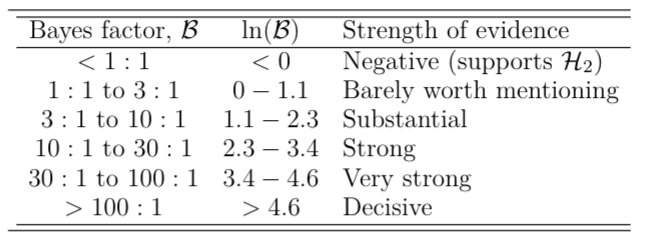

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.
  * Remember: "***GIGO***" ***= Garbage In, Garbage Out***. If we use our powerful statistics to rank a bunch of lousy models, that's our fault.

### Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

- In **classical hypothesis testing** we can ask whether or not a single model provides a good description of the data.  
- In **Bayesian hypothesis testing**, we need to have an alternative model to compare to.


Here is another example of a recent paper from my research field: *Who Ordered That? Unequal-mass Binary Black Hole Mergers Have Larger Effective Spins* by Callister et al [arxiv:2106.00521](https://arxiv.org/abs/2106.00521). Using an exquisitely Bayesian approach, they look for correlations between the masses and the spins of the binary black holes detected by LIGO. Good stats in there!



---

## Example: one piece or two pieces?

It is easy to lose sight of the big picture with all of this probability calculus, so let's zoom out to a simple example:

(example adtapted from that of [David Kirby](https://github.com/dkirkby/MachineLearningStatistics) for a non-US audience)
![](https://github.com/dkirkby/MachineLearningStatistics/blob/master/notebooks/img/ModelSelection/OccamFactor.jpg?raw=true)

**DISCUSS:** Study the observed image $D$ above with two models in mind:
 - $M_1$: The image shows a single piece of paper.
 - $M_2$: The image shows two pieces of paper.

Are both models possible? Give some arguments for why $M_2$ is unlikely. Are your arguments based on prior knowledge?

Both models are certainly possible since the ruler could be hiding the fact that these are two pieces of paper side by side.

However, $M_2$ is unlikely because:
 - This looks like a standard (A4) sheet of paper, as supported its dimensions according to the ruler.
 - It would be a remarkable coincidence for two sheets of paper to be perfectly lined up like this.
 
The first argument is based on our prior knowledge, such as:
 - I've seen many pieces of paper before and I'm familiar with the A4 proportions.
 - Most common rules have centimeters written on them.
 
Therefore, this type of argument shows up in the ratio of model priors, $P(M_1) / P(M_2)$ in the odds ratio above.
 
However, the second argument is a statement about probabilities that does not rely on any prior knowledge. Instead, it shows up in the Bayes factor above. To see how this happens, we need to define the parameters for each model. For each piece of paper, use four parameters:
 - $(x,y)$ of the top-left corner, which could be anywhere in the image.
 - width $w$ and height $h$ of the paper, which range over the full image width and height.
 
The likelihoods of $M_1$ and $M_2$ are then integrals over four and eight parameters, respectively:
$$
P(D\mid M_i) = \int d\Theta_i\, P(D, \Theta_i\mid M_i) \; .
$$
For $M_2$, the likelihood of the observed image $D$ will be zero except when the parameters of the second piece of paper have it line up perfectly under the ruler. Since this represents a small fraction of the full range of $M_2$ parameters, $P(D\mid M_2)$ is heavily penalized compared with $P(D\mid M_1)$, leading to a large Bayes factor.

This is an example of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor) in action: Bayesian inference prefers the simplest explanation (model), independently of any prior knowledge.

---

## Example: Coin flip<a class="anchor" id="twob"></a>

Let's look at an example using coin flips. Let's assume we have $N$ draws and $k$ are "success" (say, heads). 

We will compare two hypotheses:

- **M1**: We trust the guy. The coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), with a prior given by a delta function, $\delta(b-b_\ast)$,
- **M2**: They are cheating. The heads probability $b$ is unknown, with a uniform prior in the range 0–1.

Basically in **M1** we know about the fairness of the coin. In **M2** we don't know anything about the fairness of the coin.

The model that we need (parametrized by the probability of success $b$, with $k$ successes) is the *binomial distribution*:

  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model **M2** the prior for $b$ is flat in the range 0-1 and the product of the data likelihood and prior is same as above. However, for model **M1** the prior is a  delta function $\delta(b-b_\ast)$ and we get for the product of the data likelihood and prior (which picks out $b=b_\ast$) 

$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the **odds ratio** is given by 

$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$

as illustrated in the following figure. 


/Users/dgerosa/box/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


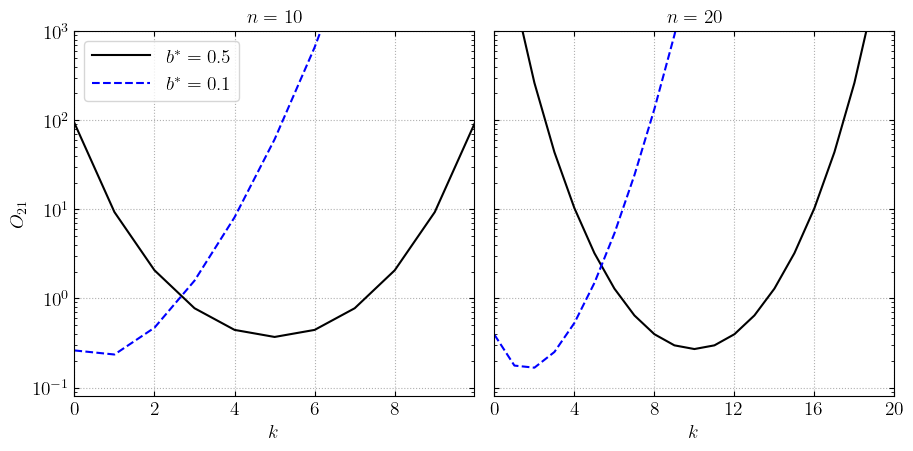

In [8]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)


@np.vectorize
def odds_ratio(n, k, bstar):
    """Odds ratio between M_2, where the heads probability is unknown,
    and M_1, where the heads probability is known to be `bstar`, evaluated
    in the case of `k` heads observed in `n` tosses.

    Eqn. 5.25 in the text
    """
    factor = 1. / (bstar ** k * (1 - bstar) ** (n - k))
    f = lambda b: b ** k * (1 - b) ** (n - k)

    return factor * integrate.quad(f, 0, 1)[0]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.13, right=0.95, wspace=0.05, bottom=0.15)

subplots = [121, 122]
n_array = [10, 20]

linestyles = ['-k', '--b']
bstar_array = [0.5, 0.1]

for subplot, n in zip(subplots, n_array):
    ax = fig.add_subplot(subplot, yscale='log')
    k = np.arange(n + 1)

    # plot curves for two values of bstar
    for ls, bstar in zip(linestyles, bstar_array):
        ax.plot(k, odds_ratio(n, k, bstar), ls,
                label=r'$b^* = %.1f$' % bstar)

    if subplot == 121:
        ax.set_xlim(0, n - 0.01)
        ax.set_ylabel(r'$O_{21}$')
        ax.legend(loc=2)
    else:
        ax.set_xlim(0, n)
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlabel('$k$')
    ax.set_title('$n = %i$' % n)
    ax.set_ylim(8E-2, 1E3)
    ax.xaxis.set_major_locator(plt.MultipleLocator(n / 5))
    ax.grid()


plt.show()

And note the nice numpy trick `@np.vectorize`, which allows you to magically make a scalar function array-compatible. If you've never seen it, the `@` is a [python decorator](https://realpython.com/primer-on-python-decorators/), which an extremely powerful structure.

This figure illustrates the behavior of $O_{21}$ as a function of $k$ for two different values of $N$ and for two different values of $b_\ast$: $b_\ast = 0.5$  (**M1**: the coin is fair) and $b_\ast = 0.1$ (**M1**: the coin is biased to tails). 

*The ability to distinguish  the two hypothesis **improves** with the sample size.*

For example:
- when $b_\ast = 0.5$ and $k/N = 0.1$ ($k=1$ on the left and $k=2$ on the right), the odds ratio in favor of **M2** increases from $\sim 9$ for $N=10$ to $\sim 263$ for $N=20$. 
- when k = $b_\ast N$, the odds ratio is $0.37$ for $N=10$ and 0.27 for $N=20$. 
- **the simpler model is favored by the data**, and the support strengthens with the sample size. 

**NOTE** 
- *$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$.* 
- To build strong evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as $N > 157$ tosses. 
- With N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and the corresponding odds ratio is $O_{21} \approx 1/80$.

***Frequentist Versus Bayesian***

In the **frequentist approach**, we ask whether we can reject the "null hypothesis" that our coin is fair. Specifically, we ask whether a given $k$ is a very unusual outcome (at some significance level $\alpha$, say $\alpha=0.05$) for a fair coin with $b_\ast = 0.5$ and with a given N. 

In the **Bayesian approach**, we offer an alternative hypothesis that the coin has an unknown heads probability. While this probability can be estimated from provided data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed hypotheses. 

## Approximate Bayesian Model Comparison <a class="anchor" id="three"></a>

While the full *Odds Ratio* is the ultimate goal, it can be costly to compute. So we have some *approximate methods* that balance between ***goodness of fit*** and ***model complexity***. 

I don't think one should use these but in case you find them around... (see the Ivezic textbook for details)

#### Akaike information criterion (AIC) 

$${\rm AIC} \equiv -2 \ln [L_0(M)] + 2k + \frac{2k(k+1)}{N-k-1}.$$

#### Bayesian information criterion (BIC)

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N.$$ 

When two models are compared, **the model with the smaller BIC/AIC value wins**. If the models are equally successful in describing the data (i.e., they have the same value of $L_0(M)$), then the model with fewer free parameters wins. 

##  Practical Evidence Evaluation & Model Selection <a class="anchor" id="two"></a>

We've discussed Bayesian parameter estimation algorithms in detail. Crucially, all you get out of an MCMC are **samples** from the posteriors. You do not get the evidence (denominator in Bayes theorem).

But the evidence is crucial in model comparison... How about it? We already have the AIC and BIC as proxies. Grid-based methods for integrating the likelihood $\times$ prior are far too crude. 

There are some further numerical techniques that we'll briefly discuss, before looking at examples of **Nested Sampling** algorithms to compute the Bayesian evidence. 

## (i) Savage-Dickey Density Ratio

This is great for when we want to compare models that have nested parameters, e.g. (1) a model with just noise, and (2) a model with a signal and noise. 

We need to be able to identify a parameter in the signal model that acts as an amplitude, $A$, that can effectively switch the signal off when it is zero. 

An example from my research field, gravitational-astronomy, is testing General Relativity. Suppose you want to test a theory which is more generic than GR (say the graviton has a non-zero mass, which implies a dispersion relation for the emitted waves), in that case GR is a special case ($m=0$) of the more generic theory.


With MCMC sampling we can map out the full parameter posterior distribution of model (2). We need to make sure we get good mixing and exploration of the parameter $A$ so that we can reconstruct its posterior density at $A=0$. 

The Bayes factor in favor of a signal being present in the data can be computed using the **[Savage-Dickey Density Ratio](https://www.jstor.org/stable/2958475?casa_token=Dc8wjaKRj5UAAAAA%3A4IhKgqNXc4jpan6hRxW7tBpXTI4i2236BulPTRxj4FcivD988vqJw-N75Dtw7z4Lh3YtPsDIceS8NDtIXAIRIO1T227h9VYZ2prQpwb46WLBB0GGz8w&seq=1#metadata_info_tab_contents)** approximation,

$$ \mathcal{B} =  \frac{p(A=0)}{p(A=0|d)}$$

which is the prior density at $A=0$ divided by the conditional posterior density at $A=0$. We can easily compute the latter by running a density estimatore on the posterior samples in $A$ and reading off the normalized pdf at $A=0$.


### A proof of the Savage-Dickey density ratio

The best derivation I could find comes from [The Book of Statistical Proofs](https://statproofbook.github.io/P/bf-sddr.html), which is an amazing resource BTW.

Our two hypoteses are:

- $M_1$. The narrow model, which is equivalent to $M_2$ with $A=0$. 
- $M_2$. The broad model, described by some parameters $\Theta$ and an additional parameter $A$.

Formmaly one has

$M_1: M_2 \cup \{ A=0 \}$

The Bayes factor we want is

$$B = \frac{p(d | M_2)}{p(d | M_1)} = \frac{p(d | M_2)}{p(d | A=0, M_2)}$$

Now let's remember Bayes rule (if I want to flip $d$ and $A=0$ then...)

$$ p(d | A=0, M_2) = p(A=0 | d, M_2) \frac{p(d | M_2)}{p(A=0, M_2)} $$

And so we have

$$B = \frac{p(A=0, M_2)}{p(A=0 | d, M_2)} $$

It's now easy to recognize the terms: the numerator is the marginalized prior under the broad model evaluated at the constraint given by the narrow model, and the denominator is the marginalized posterior under the broad model evaluated at the constraint given by the narrow model. 

The word *marginalized* is important here. These models can (and in generally will) depend on other common parameters, but all it matters are the marginalized distributions.

Also note how the final results only depend on the broad model $M_2$. One does not need to run twice! A single parameter-estimation run is enough! But then I need an additional density estimator. 

Of course, this only works if the models are nested one inside the other.


## (ii) Product-space Sampling

The name sounds fancy, but is super easy. In this type of model comparison, we never explicitly try to compute the Bayesian evidence. 

- We run a big MCMC chain that includes all parameters of all models, in addition to a model indexing parameter, $n$. 
- We define distinct ranges for this parameter, such that in certain sampling ranges it will trigger one of the model likelihoods to be used, e.g. if $-0.5<n<0.5$ use the likelihood for model $1$. 
- After sampling sufficiently long, the MCMC chain will spend different amounts of time in differnt regions of $n$ in proportion to the Bayesian odds ratio. 
- Hence, the ratio of samples in model sub-ranges of $n$ gives the Bayesian odds ratio. Simple!
- This is heavily used in gravitational-wave searches for Pulsar Timing arrays, see [https://arxiv.org/abs/1801.02617](https://arxiv.org/abs/1801.02617), [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496), and [https://arxiv.org/abs/2006.04810](https://arxiv.org/abs/2006.04810). 
- Refs [here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02042.x) and [here](https://amstat.tandfonline.com/doi/abs/10.1198/10618600152627924?casa_token=Kgpt2ZvdMrcAAAAA%3Al5JB7EitQ7MjPmxBObu2XJXocZCE1tI2-ZAceCwBjJOi2TRajF7SaxFcQjo1Nn5AF9q6vKhkxpBd&#.YEZH4F1KiLo).

## (iii) Thermodynamic Integration

This technique is pretty fancy, and is derived from analogies with thermodynamics. It is used for exact calculation of the Bayesian evidence. 

- Many MCMC chains are launched in parallel. However, their likelihoods differ slightly in their "temperature", $T$. We actually use the inverse temperature $\beta=1/T$ when writing the math. The temperature of a chain is used to modify the likelihood as follows, where 

$$ p(d|\theta)_\beta = p(d|\theta)^\beta = p(d|\theta)^{1/T}.$$

- Thus only the $T=0$ chain corresponds to the actual model likelhiood. 
- But the other temperature chains have the effect of taking higher and higher roots of the likelihood, smoothing it out and making it more similar to the original prior. 
- These high temperature chains explore the parameter volume well, communicate back to the $T=0$ chain, and improve MCMC mixing. 
- Crucially, we can also use them in evidence computation:

$$ \ln\mathcal{Z} = \int_0^1 \langle \ln p(d|\theta)\rangle_\beta\, d\beta, $$

where we take the mean log-likelihood of each $\beta$ chain, then sum these over all temperatures to get the log-evidence. Refs [here](https://www.jstor.org/stable/2676756?casa_token=nGU-oa0w6lQAAAAA%3A8UNqj0_rBP7aZ4vocZ_NzbxKhre4WvzhbNOs_TTI_FfexQmppcxQSlxaO5PCHPZNAw9fZUmy4rPeXLe_CVJgAD2AYR6qS8D6xQDicpc1R45ZhjEtOV4&seq=1#metadata_info_tab_contents), and [here](https://link.springer.com/content/pdf/10.1007/BF01406511.pdf).



# Exam exercise

## Higgs Boson

In the [Standard Model of Particle Physics](https://en.wikipedia.org/wiki/Standard_Model), particles not only make up the things that we see, but also their interactions (aka the forces, with the notable exception of gravity). 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Standard_Model_of_Elementary_Particles.svg/800px-Standard_Model_of_Elementary_Particles.svg.png)




Not only that, but the very fact that particles acquire mass is also regarded as an interaction. The particle responsible for that is called Higgs Boson. [Discovered in 2012](https://atlas.cern/Discover/Physics/Higgs) it was the last of these particles to be observed and completed the puzzle above (a puzzle that now is almost too complete!).

This amazing discovery needed the massive facility LHC at Cern (Geneva). The idea is to collide very energetic particles and hope that the particle you want comes out of the collision:

![](https://cds.cern.ch/images/CERN-MI-0807031-01/file?size=large)

![](https://cds.cern.ch/images/CERN-EX-0511013-01/file?size=large)



From a data-analysis perspective, results look like this:


![](https://cms.cern/sites/default/files/field/image/image1_1.png)

In this case they looked collisions which have to photons ($\gamma$) as products. Most of these collisions are made by something else, but a small fraction of them is due to the Higgs boson ($H$). 

So we have a background (that powerlaw-like feature) and then a tiny signal (that gaussianl-like feature).

Now, I've taken this data (which is my own simulation of the above process):

Text(0, 0.5, 'number of event per mass bin [$10^3$ Gev$^(-1)$]')

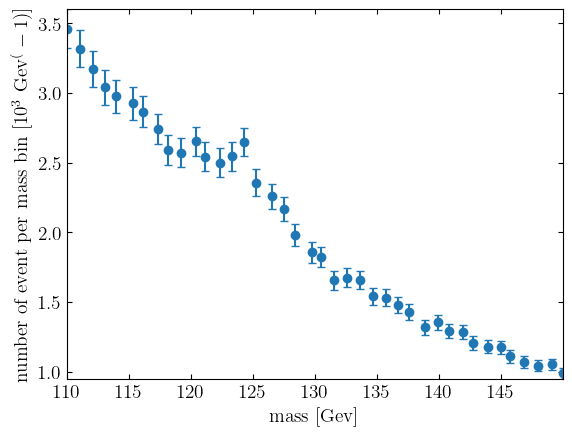

In [30]:
mass, eventpermassbin, eventerr = np.loadtxt('../datasets/boson.txt',unpack=True)

plt.errorbar(mass, eventpermassbin, eventerr,fmt='o')

plt.xlabel('mass [Gev]')

plt.ylabel('number of event per mass bin [$10^3$ Gev$^(-1)$]')

### Your tasks: 

**Given these data, it the Higgs boson truly there?**

- Come up with a model for both the background and the supposed signal (hint: read above)
- Write down the likelihood and your priors.
- Run an MCMC *assuming that the signal is there* and estimate the parameters of both signal and background.
- Identify the parameter in your model that is equal to zero when the signal is absent.
- Build a density estimator (you decide which one!) on the marginalized posterior distribution of that parameter.
- Evaluate the Bayes factor in favor of the signal using the Savage-Dickey trick
- So, did we discover the Higgs boson?